This notebook will address the importance of campaign financing on the share of votes for the primary. This will be done using quantile regressions applied separately on data containing only democratic house of representatives and republican house of represenatives.

The data prep and cleaning was mostly done along with my project for data 102 class. However, more markdowns and comments have been added to better show the data preparation process. 

1. Data Prep and cleaning

There will be two datasets: Current campaigns and Democratic Candidates. Current Campaigns contains financial campaign data on various candidates. Democratic Candidates contains election data such as proportion of votes along with endorsements from prominent political individuals and groups. The first task is to merge these two datasets in order to regress total receipts from the current campaign dataset on the primary vote column from the democratic candidates data.

In [1479]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


current_campaign = pd.read_csv("Current Campaigns.txt", sep='|', header=None)
correct_headers = [
    "CAND_ID", "CAND_NAME", "CAND_ICI", "PTY_CD", "CAND_PTY_AFFILIATION",
    "TTL_RECEIPTS", "TRANS_FROM_AUTH", "TTL_DISB", "TRANS_TO_AUTH",
    "COH_BOP", "COH_COP", "CAND_CONTRIB", "CAND_LOANS", "OTHER_LOANS",
    "CAND_LOAN_REPAY", "OTHER_LOAN_REPAY", "DEBTS_OWED_BY", 
    "TTL_INDIV_CONTRIB", "CAND_OFFICE_ST", "CAND_OFFICE_DISTRICT",
    "SPEC_ELECTION", "PRIM_ELECTION", "RUN_ELECTION", "GEN_ELECTION",
    "GEN_ELECTION_PRECENT", "OTHER_POL_CMTE_CONTRIB", "POL_PTY_CONTRIB",
    "CVG_END_DT", "INDIV_REFUNDS", "CMTE_REFUNDS"
]

limited_headers = correct_headers[:len(current_campaign.columns)]

current_campaign.columns = limited_headers
current_campaign

,CAND_ID,CAND_NAME,CAND_ICI,PTY_CD,CAND_PTY_AFFILIATION,TTL_RECEIPTS,TRANS_FROM_AUTH,TTL_DISB,TRANS_TO_AUTH,COH_BOP,...,SPEC_ELECTION,PRIM_ELECTION,RUN_ELECTION,GEN_ELECTION,GEN_ELECTION_PRECENT,OTHER_POL_CMTE_CONTRIB,POL_PTY_CONTRIB,CVG_END_DT,INDIV_REFUNDS,CMTE_REFUNDS
0,H8AK00132,"SHEIN, DIMITRI",C,1,DEM,209916.04,0.00,209574.16,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,0.00,0.0,12/31/2018,0.00,0.0
1,H6AK00045,"YOUNG, DONALD E",I,2,REP,1234680.31,0.00,1387687.05,0.0,269726.86,...,NaN,NaN,NaN,NaN,NaN,559861.90,0.0,12/31/2018,2700.00,500.0
2,H8AK01031,"NELSON, THOMAS JOHN",C,2,REP,9288.48,0.00,8821.97,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,0.00,0.0,12/31/2018,600.00,0.0
3,H8AK00140,"GALVIN, ALYSE",C,3,IND,1949643.68,154.70,1943398.59,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,114833.97,0.0,12/31/2018,8166.36,0.0
4,H8AL01066,"KENNEDY, ROBERT JR.",C,1,DEM,166845.21,0.00,166845.21,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,7750.00,0.0,12/31/2018,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2671,S8WV00150,"BLANKENSHIP, DON",C,3,CON,4165210.09,0.00,4165209.19,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,0.00,0.0,10/17/2018,0.00,0.0
2672,S8WY00189,"TRAUNER, GARY",C,1,DEM,910722.70,0.00,910723.29,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,46000.00,0.0,12/07/2018,10572.32,0.0
2673,S4WY00097,"HARDY, CHARLES E",C,2,REP,9058.00,0.00,8891.00,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,0.00,0.0,12/31/2018,0.00,0.0
2674,S6WY00068,"BARRASSO, JOHN A",I,2,REP,5667279.48,256656.69,4458971.93,0.0,2749487.00,...,NaN,NaN,NaN,NaN,NaN,2555865.00,0.0,12/31/2018,55404.00,47500.0


Drop any nan values in "Primary %" and filter to only contain house of representatives.

In [1480]:
# Import Democratic Candidate Dataset
dem = pd.read_csv('dem_candidates.csv', encoding='latin1')
# Drop nan values
dem = dem.dropna(subset=["Primary %"])

rep = pd.read_csv('rep_candidates.csv', encoding='latin1')
# Drop nan values
rep = rep.dropna(subset=["Primary %"])

dem_house = dem[dem["Office Type"] == "Representative"]
rep_house = rep[rep["Office Type"] == "Representative"]

Filter the current campaign data to only contain democrats

In [1481]:
dem_current_campaign = current_campaign[current_campaign["CAND_PTY_AFFILIATION"]=="DEM"]

To merge these datasets, we will merge by name, district, and state. However, the names have slightly different formats and at times small typos. First, we will reformat the currernt_campaigns candidate names to have the same structure as the democratic candidate names. Current_campaigns has the following format: last name, first name. We will bring everything before the comma in front of the first name. 

In [1482]:
# There is only one individual with no comma in cand_name [ADAM DAVIDSON DEMARCO]
dem_current_campaign=dem_current_campaign[dem_current_campaign["CAND_NAME"].str.contains(",")]

This function reformats the "CAND_NAME" to place the last name after the first name (so everything before the comma)

In [1483]:
def reformat_name(name):
    parts = name.split(',')
    if len(parts) == 2:
        last_name, first_name = parts
    elif len(parts) > 2:
        last_name, first_name = parts[0], parts[1]
    else:
        # For names without a comma or improperly formatted, return as is or handle specifically
        return name.lower()
    
    return f"{first_name.strip().lower()} {last_name.strip().lower()}"

dem_current_campaign['CAND_NAME'] = dem_current_campaign['CAND_NAME'].apply(reformat_name)

dem_house should already be in the format with first name and then last name

In [1484]:
dem_house.loc[:,"Candidate"] = dem_house["Candidate"].str.lower()

Now lets just standardize each of the columns to make each of the names as similar as possible.

In [1485]:
def standardize_names(name):
    return name.strip().lower().replace('.', '').replace(',', '').replace('-', '')

dem_current_campaign.loc[:,'CAND_NAME'] = dem_current_campaign['CAND_NAME'].apply(standardize_names)
dem_house.loc[:,'Candidate'] = dem_house['Candidate'].apply(standardize_names)

The fuzzywuzzy package will help create a function to match the closest name from dem_current_campaign['CAND_NAME'] to dem_house['Candidate'] and return None if there is no name that is at least 75% the same

In [1486]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def get_best_match(name, candidate_list, score_cutoff=95):
    best_match = process.extractOne(name, candidate_list, scorer=fuzz.ratio)
    if best_match and best_match[1] >= score_cutoff:
        return best_match[0]  # Return the best match name if score is above cutoff
    return None  # Return None if no matches are found above the cutoff

# Create a list of candidates for easier access
candidate_list = dem_house['Candidate'].tolist()

# Map the best match names with a score cutoff
dem_current_campaign['Best_Match_Candidate'] = dem_current_campaign['CAND_NAME'].apply(lambda x: get_best_match(x, candidate_list, 75))

After finding the names from the dem_current_campaign dataframe that are similar to the candidates in dem_house, the dem_current_campaign dataframe can now be merged with the dem_house on the best_match_candidate which contains the same names from the dem_house 'Candidate' column.

In [1487]:
# Join on the matched names; this will automatically ignore rows where Best_Match_Candidate is None
result_df_dem = pd.merge(dem_current_campaign.dropna(subset=['Best_Match_Candidate']), dem_house, left_on='Best_Match_Candidate', right_on='Candidate', how='inner')
result_df_dem

,CAND_ID,CAND_NAME,CAND_ICI,PTY_CD,CAND_PTY_AFFILIATION,TTL_RECEIPTS,TRANS_FROM_AUTH,TTL_DISB,TRANS_TO_AUTH,COH_BOP,...,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?
0,H8AL01066,robert jr kennedy,C,1,DEM,166845.21,0.00,166845.21,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S8AL00365,robert jr kennedy,C,1,DEM,37129.00,0.00,37129.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H8AL01082,lizzetta hill mcconnell,C,1,DEM,5127.00,0.00,6021.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H8AL02163,audri scott 1955 williams,C,1,DEM,35365.02,0.00,35210.22,0.0,279.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H8AL02197,tabitha kay isner,C,1,DEM,524941.35,0.00,524941.35,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,H8WV02107,aaron scheinberg,C,1,DEM,588749.56,125657.35,526982.21,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN
544,H8WV02115,talley sergent,C,1,DEM,705197.45,14067.96,683790.40,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
545,H8WV03121,shirley love,O,1,DEM,64000.00,0.00,15105.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,NaN
546,S8MS00287,michael espy,O,1,DEM,7488521.96,103000.00,7194351.26,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here I am getting the district number from "District" and making sure the "District #" from dem_house dataset matches the "CAND_OFFICE_DISTRICT". The rows that do not match in district and state are removed.

In [1488]:
#These rows didn't have district numbers at the end
"132	U.S. House Montana At-large District	0"
"133	U.S. House Montana At-large District	0"
"134	U.S. House Montana At-large District	0"

result_df_dem["District #"] = result_df_dem['District'].str.split(" ").str[-1]
result_df_dem["District #"] = result_df_dem['District #'].replace({"District":0}).astype(int)
result_df_dem = result_df_dem[result_df_dem['District #'] == result_df_dem['CAND_OFFICE_DISTRICT']]
result_df_dem = result_df_dem[result_df_dem['State'] == result_df_dem["CAND_OFFICE_ST"]]
result_df_dem

,CAND_ID,CAND_NAME,CAND_ICI,PTY_CD,CAND_PTY_AFFILIATION,TTL_RECEIPTS,TRANS_FROM_AUTH,TTL_DISB,TRANS_TO_AUTH,COH_BOP,...,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,District #
0,H8AL01066,robert jr kennedy,C,1,DEM,166845.21,0.00,166845.21,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,H8AL01082,lizzetta hill mcconnell,C,1,DEM,5127.00,0.00,6021.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,H8AL02163,audri scott 1955 williams,C,1,DEM,35365.02,0.00,35210.22,0.0,279.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,H8AL02197,tabitha kay isner,C,1,DEM,524941.35,0.00,524941.35,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
5,H8AL03054,mallory hagan,C,1,DEM,467514.71,0.00,464472.20,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,H8VA10171,paul pelletier,C,1,DEM,651741.75,0.00,651741.75,0.0,0.0,...,NaN,NaN,No,NaN,NaN,NaN,NaN,No,NaN,10
542,H8WV01067,ralph baxter,C,1,DEM,652981.25,0.00,636052.25,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
543,H8WV02107,aaron scheinberg,C,1,DEM,588749.56,125657.35,526982.21,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,2
544,H8WV02115,talley sergent,C,1,DEM,705197.45,14067.96,683790.40,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,2


The cell below will follow the same steps used to setup the Democratic House of Representatives dataset but now for the Republican House of Representatives.

In [1489]:
rep_current_campaign = current_campaign[current_campaign["CAND_PTY_AFFILIATION"]=="REP"]
rep_current_campaign=rep_current_campaign[rep_current_campaign["CAND_NAME"].str.contains(",")]
rep_current_campaign['CAND_NAME'] = rep_current_campaign['CAND_NAME'].apply(reformat_name)
rep_house.loc[:,"Candidate"] = rep_house["Candidate"].str.lower()
rep_current_campaign['CAND_NAME'] = rep_current_campaign['CAND_NAME'].apply(standardize_names)
rep_house['Candidate'] = rep_house['Candidate'].apply(standardize_names)
candidate_list = rep_house['Candidate'].tolist()
rep_current_campaign['Best_Match_Candidate'] = rep_current_campaign['CAND_NAME'].apply(lambda x: get_best_match(x, candidate_list, 60))
result_df = pd.merge(rep_current_campaign.dropna(subset=['Best_Match_Candidate']), rep_house, left_on='Best_Match_Candidate', right_on='Candidate', how='inner')
result_df["District #"] = result_df['District'].str.split(" ").str[-1]
result_df["District #"] = result_df['District #'].replace({"District":0}).astype(int)
result_df = result_df[result_df['District #'] == result_df['CAND_OFFICE_DISTRICT']]
result_df = result_df[result_df['State'] == result_df["CAND_OFFICE_ST"]]
result_df

/var/folders/lp/sx_szbvj68d32j4481mjxjzr0000gn/T/ipykernel_10932/2662234744.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rep_house['Candidate'] = rep_house['Candidate'].apply(standardize_names)


,CAND_ID,CAND_NAME,CAND_ICI,PTY_CD,CAND_PTY_AFFILIATION,TTL_RECEIPTS,TRANS_FROM_AUTH,TTL_DISB,TRANS_TO_AUTH,COH_BOP,...,Right to Life Endorsed?,Susan B. Anthony Endorsed?,Club for Growth Endorsed?,Koch Support?,House Freedom Support?,Tea Party Endorsed?,Main Street Endorsed?,Chamber Endorsed?,No Labels Support?,District #
5,H8CA39232,shawn nelson,O,2,REP,694900.84,0.0,685895.42,0.00,0.00,...,NaN,No,NaN,NaN,NaN,No,No,NaN,NaN,39
9,H6FL27049,maria m peiro,O,2,REP,15501.32,0.0,14938.40,0.00,0.00,...,Yes,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,27
19,H8CT05229,richard dupont,O,2,REP,139031.46,0.0,138585.72,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
22,H8TX06233,ron wright,O,2,REP,707057.75,0.0,704664.14,0.00,0.00,...,Yes,NaN,Yes,NaN,NaN,Yes,NaN,NaN,NaN,6
27,H8MS03125,michael patrick guest,O,2,REP,985526.20,0.0,952203.20,1000.00,0.00,...,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,H8WI01164,kevin adam steen,O,2,REP,48894.90,0.0,47141.60,0.00,0.00,...,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
774,H8WI01172,bradley thomas dr boivin,O,2,REP,5380.00,0.0,5380.00,44.57,0.00,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
775,H8WV03055,rupert wilson jr phillips,O,2,REP,284462.45,0.0,284462.45,0.00,0.00,...,NaN,No,NaN,NaN,NaN,NaN,No,NaN,NaN,3
776,H8WV03071,ayne amjad,O,2,REP,18650.00,0.0,19135.34,0.00,-55.86,...,NaN,No,NaN,NaN,NaN,NaN,No,NaN,NaN,3


Everything below is new and not from the DATA 102 project.

2. EDA

Now lets run some EDA on both the republican and democrat merged data. First log transform the TTL_RECEIPTS to get rid of the heavy right skew. We will use the bins from the histogram to form bins for each cell for the upcoming quantile regression.

In [1490]:
# Log both democrat and republican "TTL_RECEIPTS"
result_df_dem.loc[:,"log_TTL_RECEIPTS"] = np.log(result_df_dem["TTL_RECEIPTS"])
result_df.loc[:,"log_TTL_RECEIPTS"] = np.log(result_df["TTL_RECEIPTS"])
# Make sure there are no -inf (there are only three in republican dataset)
result_df = result_df[result_df['log_TTL_RECEIPTS'] != -np.inf]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


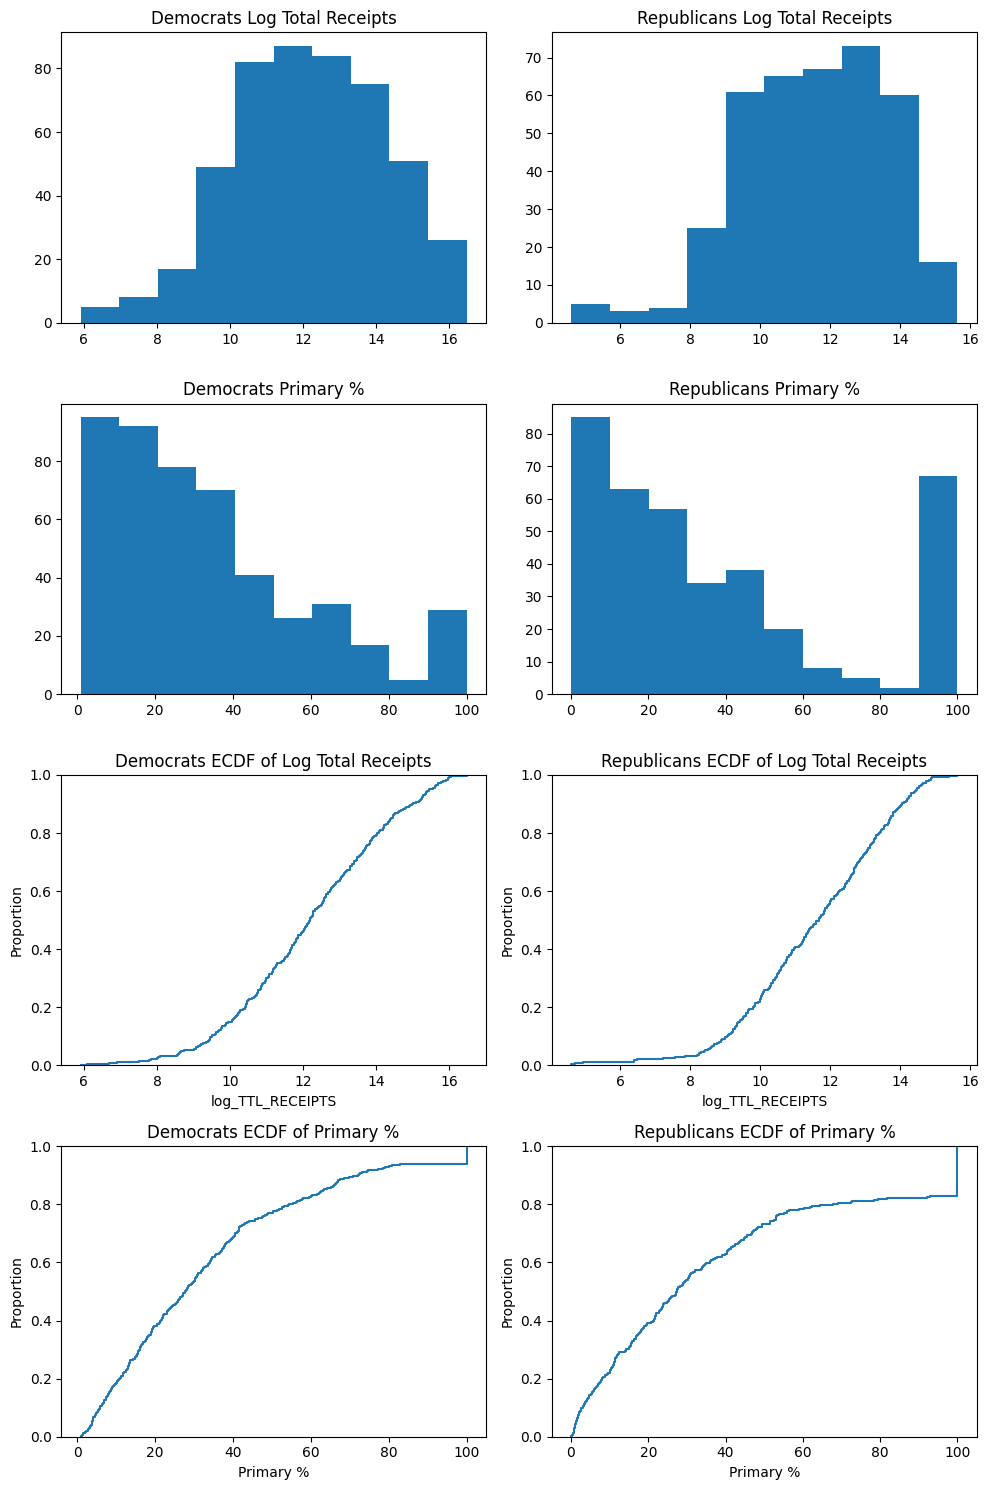

In [1491]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15)) 

# Plotting for Democrats
axes[0, 0].hist(result_df_dem["log_TTL_RECEIPTS"])
axes[0, 0].set_title('Democrats Log Total Receipts')

axes[1, 0].hist(result_df_dem["Primary %"])
axes[1, 0].set_title('Democrats Primary %')

sns.ecdfplot(data=result_df_dem["log_TTL_RECEIPTS"], ax=axes[2, 0])
axes[2, 0].set_title('Democrats ECDF of Log Total Receipts')

sns.ecdfplot(data=result_df_dem["Primary %"], ax=axes[3, 0])
axes[3, 0].set_title('Democrats ECDF of Primary %')

# Plotting for Republicans
axes[0, 1].hist(result_df["log_TTL_RECEIPTS"])
axes[0, 1].set_title('Republicans Log Total Receipts')

axes[1, 1].hist(result_df["Primary %"])
axes[1, 1].set_title('Republicans Primary %')

sns.ecdfplot(data=result_df["log_TTL_RECEIPTS"], ax=axes[2, 1])
axes[2, 1].set_title('Republicans ECDF of Log Total Receipts')

sns.ecdfplot(data=result_df["Primary %"], ax=axes[3, 1])
axes[3, 1].set_title('Republicans ECDF of Primary %')

plt.tight_layout()
plt.show()



Starting with the histograms at the top, both distributions have a normal distribution. This normalization of the data through log transformation is beneficial, since it makes total receipts more suitable for regression. However, it is important to note the subtle differences between them. The Republican histogram displays a slight left skew, indicating that a larger number of Republican candidates might be operating with higher funding levels compared to the democrats. In contrast, the distribution for Democrats is more symmetric, suggesting a more normal distribution of campaign funds across their candidates.

Moving on to the next two distributions, covering the primary share of votes distribution for both parties, both of them have a generally decreasing amount of candidates who have a proportion of votes in the primaries. However, the republican house of representatives have a greater amount of candidates who are peforming very well in the republican primaries. Since each of these distribution do not have a normal distribution, quantile regression will hopefully better handle these two heavily skewed distributions.

The next two pair of plot will help us check if our predictor variable and response variable are continuous. Although the log total receipts variable is continuos, voter share in primaries does is not continuous throughtout the distribution. We can see above vote share above 85% stops being continuous. This can lead into issues when applying quantile regression later on, especially for the higher quantiles that will have these non continuous data.

3. Quantile Regression

In [1492]:
quantile_range = np.arange(0.05,0.96,0.01)

In [1493]:
def quantile_reg(result_df, obs_threshold, amount_diff,quantiles):
    result_df = result_df.copy()
    alpha  = 0.05 
    z_crit = sp.stats.norm(loc=0, scale=1).ppf(1-alpha/2) # critical value from standard normal distribution
    results = {'TTL_RECEIPTS_Range':[],'Mid_TTL_RECEIPTS':[],'N': [], 'tau' : [], 'Q_hat': [],'lower_CI' : [], 'upper_CI' : [], 'SE_hat' : []}
    amount_bin_start = min(result_df["log_TTL_RECEIPTS"])
    max_amount = max(result_df["log_TTL_RECEIPTS"])

    while amount_bin_start + amount_diff <= max_amount:
        subsample = result_df.loc[(amount_bin_start >= result_df["log_TTL_RECEIPTS"]) & (result_df["log_TTL_RECEIPTS"] <= amount_bin_start + amount_diff)]
        N = len(subsample)
        if N >= obs_threshold:
            Y = subsample['Primary %']
            X = np.sort(Y)
            for tau in quantiles:
                l      = ((N*tau*(1-tau))**(1/2))*z_crit
                j      = max(0,int(np.floor(N*tau - l))-1)
                k      = min(N-1,int(np.ceil(N*tau + l))-1)
                results['TTL_RECEIPTS_Range'].append('[{},{})'.format(amount_bin_start, amount_bin_start + amount_diff))
                results['Mid_TTL_RECEIPTS'].append((amount_bin_start +  amount_bin_start + amount_diff)/2)
                results['N'].append(N)
                results['tau'].append(tau)
                results['Q_hat'].append(np.quantile(X, tau))
                results['lower_CI'].append(X[j])
                results['upper_CI'].append(X[k])
                results['SE_hat'].append(((N*(X[k]-X[j])**2)/(4*z_crit**2))**(1/2))
        else:
            print("The TTL_RECEIPTS_Range = [{},{}) doesn't have {} obs".format(amount_bin_start,amount_bin_start + amount_diff,obs_threshold))
        amount_bin_start = amount_bin_start + amount_diff
    return pd.DataFrame.from_dict(results)

The republican results will have a lower observation threshold since it has less available data

In [1494]:
results_dem = quantile_reg(result_df_dem, 15, 0.2, quantile_range)
results_rep = quantile_reg(result_df, 10, 0.2, quantile_range)

The TTL_RECEIPTS_Range = [5.9108237439443245,6.110823743944325) doesn't have 15 obs
The TTL_RECEIPTS_Range = [6.110823743944325,6.310823743944325) doesn't have 15 obs
The TTL_RECEIPTS_Range = [6.310823743944325,6.510823743944325) doesn't have 15 obs
The TTL_RECEIPTS_Range = [6.510823743944325,6.710823743944325) doesn't have 15 obs
The TTL_RECEIPTS_Range = [6.710823743944325,6.910823743944325) doesn't have 15 obs
The TTL_RECEIPTS_Range = [6.910823743944325,7.110823743944326) doesn't have 15 obs
The TTL_RECEIPTS_Range = [7.110823743944326,7.310823743944326) doesn't have 15 obs
The TTL_RECEIPTS_Range = [7.310823743944326,7.510823743944326) doesn't have 15 obs
The TTL_RECEIPTS_Range = [7.510823743944326,7.710823743944326) doesn't have 15 obs
The TTL_RECEIPTS_Range = [7.710823743944326,7.910823743944326) doesn't have 15 obs
The TTL_RECEIPTS_Range = [7.910823743944326,8.110823743944326) doesn't have 15 obs
The TTL_RECEIPTS_Range = [4.605170185988092,4.805170185988092) doesn't have 10 obs
The

In [1495]:
def quantile_reg(results, quantiles):
    results = results.copy()
    results = results[results['SE_hat']!=0]
    coefs = []
    CI_low = []
    CI_upper = []
    for tau in quantiles:
        est_sample = results[results['tau']==tau]
        regr = sm.WLS(est_sample['Q_hat'], sm.add_constant(est_sample[['Mid_TTL_RECEIPTS']]), weights=1/est_sample['SE_hat']).fit()
        coefs.append(regr.params['Mid_TTL_RECEIPTS'])
        
        CI_low.append(regr.conf_int(alpha=0.05)[0]['Mid_TTL_RECEIPTS'])
        CI_upper.append(regr.conf_int(alpha=0.05)[1]['Mid_TTL_RECEIPTS'])
    
    # Plot the coefficients on TTL_RECEIIPTS and corresponding 95% CI
    plt.figure(figsize=(8,5))
    plt.plot(quantiles, coefs, color="lightcoral",linestyle='--')
    plt.fill_between(quantiles, CI_low, CI_upper, color='lightskyblue',alpha=0.8)
    plt.xlabel('Centiles')
    plt.legend(['Coefficients on TTL_RECEIPTS','95% Confidence Intervals'])

Quantile Regression applied to Democrat Data

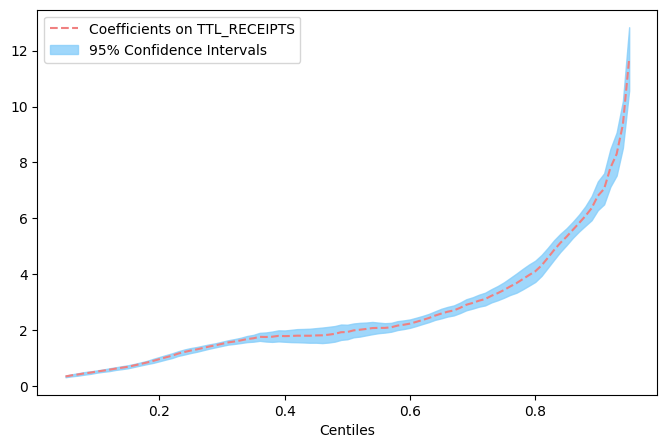

In [1496]:
quantile_reg(results_dem, quantile_range)

As we can see, the coefficients grow gradually for lower quantiles, but there is rapid growth for quantiles past 0.8. This shows us that investment into the candidates that perform better lead to even greater results in terms of votes relative to financing everyone else who isn't performing as well.

Quantile regression applied to Republican Data

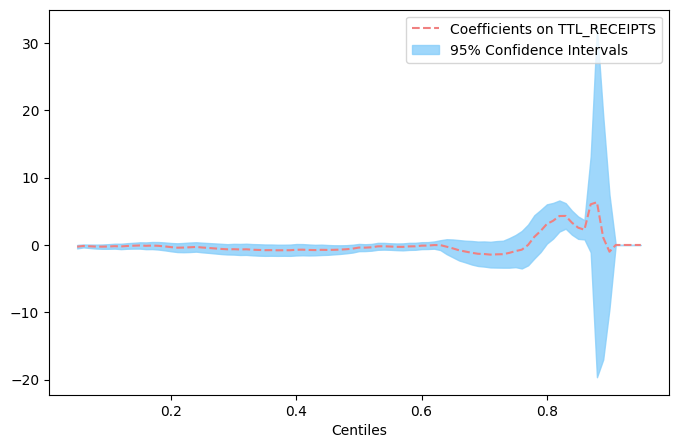

In [1497]:
quantile_reg(results_rep, quantile_range)

In contrast to the democrat results, the results show that financing barely helps out candidates beneath the 75th quantile. There is a ton a volatility after the 75th quantile, which may do to issues related to the distribution not being continuous for candidates with a higher share of votes (as discovered in the EDA section). Therefore, these results for larger quantiles may not be completely reliable, however there are signs of greater additional earnings for those in higher quantiles.

Additional Interpretations and Limitations

Based off the EDA and quantile regression results, there are differences between the republican and democratic house of representatives in terms of their finances and its relationship with primary votes. The main differing characteristic is the allocation of these finances. The democrats tend to have more of their money spread out across candidates while republicans allocate most of their money towards higher performing candidates.

The main limitations to these results come from not having enough data for both parties, but especially for the republican party, the non-continuous nature of the primary vote, and the lack generalizability.The first two limitations may lead to volatile results as seen by the republican results. In regards to the lack of generalizability, the incorporation of other variables can help reach the true effect of financing on primary vote share for each party. Further research with more domain knowledge can help address confounding variables to find better coefficients across the quantiles. With a constantly changing political environment, these results won't apply later for future primaries without consideration of the differences between each of them. In conclusion, a compilation of more data across many primaries can lead to more robust results along with the inclusion of other variables to capture more complex relationships needed to improve electoral success.